# PROJECT TITLE : SPOTIFY PLAYLIST MAKER

## Content based recommendation system to build custom automated playlists

* Python
* Machine Learning

# **Project Summary -** 

This project is a Spotify playlist maker that utilizes a content-based recommendation system built using Python. It leverages the Spotify API to access user data, including playlists, artists, and song history. 

The system analyzes the user's playlist preferences and generates custom playlists based on their song choices. The dataset used is Spotify Dataset 1921-2020, 160k+ Tracks that contains all spotify songs from 1921 to 2020. The model is trained using these tracks.


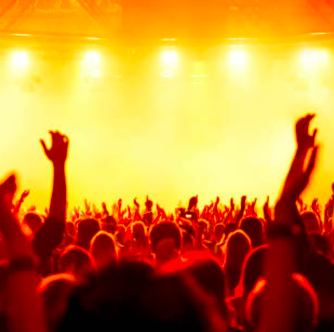

In [10]:
from IPython.display import Image
Image(filename='Spotify_1921_2020.png',height=200,width=400)

## Modules and Dependencies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/var/folders/2p/_15_n3m13q76dwjfb7s847bh0000gn/T/ipykernel_1234/2126890664.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Data Preparation

In [3]:
tracks_df = pd.read_csv('data.csv')

In [4]:
data_w_genres_df = pd.read_csv('data_w_genres.csv')

In [5]:
tracks_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

* This data is at a song level. Each row is about the song/track.
* The above data doesnt contain any genre and thus won't help us find any content. The dataset below contains genres as well.

In [6]:
data_w_genres_df.head()

genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5   
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

* 'data_w_genres_df' is an ARTIST level df. Each row is about the artist

In [7]:
data_w_genres_df.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [8]:
data_w_genres_df['genres'][0][0]

'['

Thus 'genres' column is string which looks like a list, we need to convert this string to a list.

In [9]:
data_w_genres_df['genres_upd'] = data_w_genres_df['genres'].str.strip("[]")
data_w_genres_df['genres_upd'] = data_w_genres_df['genres_upd'].str.split(',')
data_w_genres_df['genres_upd'] = data_w_genres_df['genres_upd'].apply(lambda lst: [s.strip(" ' ") for s in lst])
data_w_genres_df['genres_upd'] = data_w_genres_df['genres_upd'].apply(lambda lst: [s.replace(' ', '_') for s in lst])

In [10]:
data_w_genres_df['genres_upd'].values[0][0]

'show_tunes'

We have to do the same thing with 'artists' in tracks_df

In [11]:
tracks_df['artists'][0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [12]:
tracks_df['artists_upd'] = tracks_df['artists'].str.strip("[]")
tracks_df['artists_upd'] = tracks_df['artists_upd'].str.split(',')
tracks_df['artists_upd'] = tracks_df['artists_upd'].apply(lambda lst: [s.strip(" ' ") for s in lst])

In [13]:
tracks_df['artists_upd'][0][0]

'Sergei Rachmaninoff'

In [14]:
#need to create a song identifier because there are duplicates of the same song with different ids.
tracks_df['artists_song'] = tracks_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [15]:
tracks_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [16]:
tracks_df[tracks_df['name']=='Adore You']

valence  year  acousticness           artists  danceability  \
19425    0.569  2019        0.0237  ['Harry Styles']         0.676   
38319    0.569  2019        0.0237  ['Harry Styles']         0.676   

       duration_ms  energy  explicit                      id  \
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7   
38319       207133   0.771         0  1M4qEo4HE3PRaCOM7EXNJq   

       instrumentalness  ...  liveness  loudness  mode       name popularity  \
19425          0.000007  ...     0.102    -3.675     1  Adore You         88   
38319          0.000007  ...     0.102    -3.675     1  Adore You         77   

       release_date speechiness   tempo     artists_upd           artists_song  
19425    2019-12-13      0.0483  99.048  [Harry Styles]  Harry StylesAdore You  
38319    2019-12-06      0.0483  99.048  [Harry Styles]  Harry StylesAdore You  

[2 rows x 21 columns]

In [17]:
tracks_df.drop_duplicates('artists_song',inplace = True)

In [18]:
artists_exploded = tracks_df[['artists_upd','id']].explode('artists_upd')

In [19]:
artists_exploded_enriched = artists_exploded.merge(data_w_genres_df, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [20]:
#grouping by ids
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [21]:
artists_genres_consolidated['consolidated_genre_lists'] = artists_genres_consolidated['genres_upd'].explode().drop_duplicates().groupby(level=0).agg(list)

In [22]:
artists_genres_consolidated.head()

id                                         genres_upd  \
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_wave, new_wave_po...   
1  000GyYHG4uWmlXieKLij8u  [[alternative_hip_hop, conscious_hip_hop, minn...   
2  000Npgk5e2SgwGaIsN3ztv  [[classic_bollywood, classic_pakistani_pop, fi...   
3  000ZxLGm7jDlWCHtcXSeBe    [[boogie-woogie, piano_blues, ragtime, stride]]   
4  000jBcNljWTnyjB4YO7ojf                                               [[]]   

                            consolidated_genre_lists  
0  [[candy_pop, dance_rock, new_wave, new_wave_po...  
1  [[alternative_hip_hop, conscious_hip_hop, minn...  
2  [[classic_bollywood, classic_pakistani_pop, fi...  
3    [[boogie-woogie, piano_blues, ragtime, stride]]  
4                                               [[]]

In [23]:
tracks_df = tracks_df.merge(artists_genres_consolidated[['id', 'consolidated_genre_lists']].reset_index(drop=True), on='id', how='left')

# Feature Engineering

In [24]:
tracks_df['year'] = tracks_df['release_date'].apply(lambda x: x.split('-')[0])

In [25]:
float_cols = tracks_df.dtypes[tracks_df.dtypes == 'float64'].index.values

In [26]:
# create 5 point buckets for popularity 
tracks_df['popularity_red'] = tracks_df['popularity'].apply(lambda x: int(x/5))

In [27]:
tracks_df['consolidated_genre_lists'] = tracks_df['consolidated_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [28]:
tracks_df.head()

valence  year  acousticness         artists  danceability  duration_ms  \
0    0.177  1989         0.568         ['조정현']         0.447       237688   
1    0.352  1992         0.381          ['黑豹']         0.353       316160   
2    0.458  1963         0.987         ['黃國隆']         0.241       193480   
3    0.796  1963         0.852  ['黃國隆', '王秋玉']         0.711       145720   
4    0.704  1963         0.771         ['黃國隆']         0.610       208760   

   energy  explicit                      id  instrumentalness  ...  mode  \
0  0.2150         0  2ghebdwe2pNXT4eL34T7pW          0.000001  ...     1   
1  0.6860         0  3KIuCzckjdeeVuswPo20mC          0.000000  ...     1   
2  0.0437         0  4prhqrLXYMjHJ6vpRAlasx          0.000453  ...     1   
3  0.1110         0  5xFXTvnEe03SyvFpo6pEaE          0.000000  ...     0   
4  0.1750         0  6Pqs2suXEqCGx7Lxg5dlrB          0.000000  ...     1   

                   name  popularity  release_date speechiness    tempo  \
0            그아픔까지사랑한거야          31    1989-06-15      0.0272   71.979   
1  DON'T BREAK MY HEART          35    1992-12-22      0.0395  200.341   
2                   藝旦調          23    1963-05-28      0.0443   85.936   
3                 草螟弄雞公          23    1963-05-28      0.0697  124.273   
4                   思想起          23    1963-05-28      0.0419  124.662   

  artists_upd            artists_song               consolidated_genre_lists  \
0       [조정현]           조정현그아픔까지사랑한거야                 [[classic_korean_pop]]   
1        [黑豹]  黑豹DON'T BREAK MY HEART  [[chinese_indie, chinese_indie_rock]]   
2       [黃國隆]                  黃國隆藝旦調                                     []   
3  [黃國隆, 王秋玉]                黃國隆草螟弄雞公                                     []   
4       [黃國隆]                  黃國隆思想起                                     []   

  popularity_red  
0              6  
1              7  
2              4  
3              4  
4              4  

[5 rows x 23 columns]

In [29]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [30]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(df['consolidated_genre_lists'].apply(lambda x: " ".join(str(i) for i in x) if isinstance(x, list) else str(x) if pd.notna(x) else ''))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [31]:
complete_feature_set = create_feature_set(tracks_df, float_cols=float_cols)#.mean(axis = 0)

In [32]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  genre|_roll  \
0                           0.0          0.0             0.0          0.0   
1                           0.0          0.0             0.0          0.0   
2                           0.0          0.0             0.0          0.0   
3                           0.0          0.0             0.0          0.0   
4                           0.0          0.0             0.0          0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  ...  year|2012  \
0                     0.0              0.0              0.0  ...        0.0   
1                     0.0              0.0              0.0  ...        0.0   
2                     0.0              0.0              0.0  ...        0.0   
3                     0.0              0.0              0.0  ...        0.0   
4                     0.0              0.0              0.0  ...        0.0   

   year|2013  year|2014  year|2015  year|2016  year|2017  year|2018  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   year|2019  year|2020                      id  
0        0.0        0.0  2ghebdwe2pNXT4eL34T7pW  
1        0.0        0.0  3KIuCzckjdeeVuswPo20mC  
2        0.0        0.0  4prhqrLXYMjHJ6vpRAlasx  
3        0.0        0.0  5xFXTvnEe03SyvFpo6pEaE  
4        0.0        0.0  6Pqs2suXEqCGx7Lxg5dlrB  

[5 rows x 3077 columns]

# Connect to Spotify API

In [33]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

In [34]:
#client id and secret for my application
client_id = 'e8011845b78e446ab3c46de2f2ec4bd6'
client_secret= 'b885032d20cd487b88da24873256e397'

In [35]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [36]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [37]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8882/')

In [38]:
sp = spotipy.Spotify(auth=token)

In [40]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [41]:
id_name

{'MC+Shaan': '7GLa4iUYAP0KZ0hknowCFM'}

In [66]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [67]:
playlist = create_necessary_outputs('MC+Shaan', id_name,tracks_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [74]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)
        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [75]:
playlist

artist               name                      id  \
4  Monty Sharma  Jab Se Tere Naina  0gRNu9dVzi5aC87AI1empZ   
3   Jatin-Lalit     Chand Sifarish  5EYZZvmNAH5VZCwuzYJqoA   

                                                 url                date_added  
4  https://i.scdn.co/image/ab67616d00001e02bd848c... 2023-12-01 17:34:34+00:00  
3  https://i.scdn.co/image/ab67616d00001e02d2be31... 2023-12-01 17:34:16+00:00

/var/folders/2p/_15_n3m13q76dwjfb7s847bh0000gn/T/ipykernel_1234/2115597598.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.4, w_pad=0)


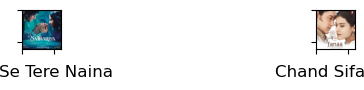

In [76]:
visualize_songs(playlist)

# Create Playlist Vector

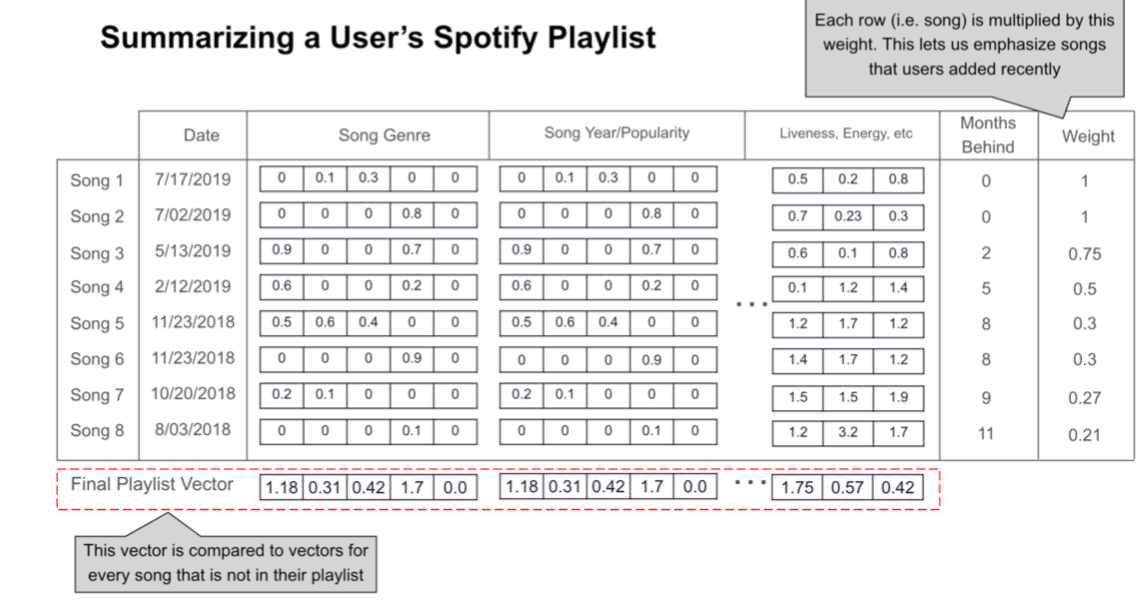

In [56]:
from IPython.display import Image
Image('summary.png')

In [57]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [59]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [60]:
complete_feature_set_playlist_vector.shape

(3076,)

# Generate Recommendations

In [61]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [63]:
playlist_top40 = generate_playlist_recos(tracks_df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

/var/folders/2p/_15_n3m13q76dwjfb7s847bh0000gn/T/ipykernel_1234/2672743570.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]


# GENERATED PLAYLIST:

In [65]:
playlist_top40.head()

valence  year  acousticness  \
45411     0.704  2007         0.279   
35649     0.517  2006         0.295   
81055     0.716  2008         0.391   
143689    0.792  2013         0.240   
80865     0.722  1983         0.628   

                                                  artists  danceability  \
45411        ['Rahat Fateh Ali Khan', 'Mahalakshmi Iyer']         0.637   
35649   ['Shankar-Ehsaan-Loy', 'Shankar Mahadevan', 'C...         0.630   
81055                                ['KK', 'Shilpa Rao']         0.382   
143689                 ['Benny Dayal', 'Shefali Alvares']         0.805   
80865               ['Kalyanji-Anandji', 'Kishore Kumar']         0.562   

        duration_ms  energy  explicit                      id  \
45411        306834   0.573         0  0u8wprNfOdcWpUlWnfMcpP   
35649        382973   0.630         0  4BTPzhEsyW3blWcxcuhLM0   
81055        333584   0.632         0  0gPgdRfB4jdGrlyXS0Vx78   
143689       252760   0.932         0  4eu27jAU2bbnyHUC3G75U8   
80865        320000   0.696         0  02zPo0Dt0R4TTFY5zLJZnK   

        instrumentalness  ...  popularity  release_date  speechiness    tempo  \
45411           0.000003  ...          58    2007-05-15       0.0491   90.017   
35649           0.000013  ...          60    2006-06-08       0.0364  107.103   
81055           0.000486  ...          62    2008-07-05       0.0411   78.936   
143689          0.000000  ...          58    2013-03-30       0.0684  106.019   
80865           0.000000  ...          56    1983-06-10       0.0397   93.801   

                                              artists_upd  \
45411            [Rahat Fateh Ali Khan, Mahalakshmi Iyer]   
35649   [Shankar-Ehsaan-Loy, Shankar Mahadevan, Carali...   
81055                                    [KK, Shilpa Rao]   
143689                     [Benny Dayal, Shefali Alvares]   
80865                   [Kalyanji-Anandji, Kishore Kumar]   

                                             artists_song  \
45411              Rahat Fateh Ali KhanBol Na Halke Halke   
35649                             Shankar-Ehsaan-LoyMitwa   
81055                                       KKKhuda Jaane   
143689                           Benny DayalBadtameez Dil   
80865   Kalyanji-AnandjiNeele Neele Ambar Par - Male V...   

                                 consolidated_genre_lists  popularity_red  \
45411   [[classic_pakistani_pop, filmi, modern_bollywo...              11   
35649   [[classic_pakistani_pop, desi_pop, filmi, mode...              12   
81055   [[desi_pop, filmi, modern_bollywood, sufi], [d...              12   
143689  [[deep_indian_pop, desi_pop, filmi, modern_bol...              11   
80865   [[classic_bollywood, desi_pop, filmi, modern_b...              11   

             sim                                                url  
45411   0.797724  https://i.scdn.co/image/ab67616d00001e027b4cb0...  
35649   0.688867  https://i.scdn.co/image/ab67616d00001e02afbf50...  
81055   0.630706  https://i.scdn.co/image/ab67616d00001e0219beb7...  
143689  0.609406  https://i.scdn.co/image/ab67616d00001e02707ea5...  
80865   0.602571  https://i.scdn.co/image/ab67616d00001e02136f87...  

[5 rows x 25 columns]

/var/folders/2p/_15_n3m13q76dwjfb7s847bh0000gn/T/ipykernel_1234/2115597598.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.4, w_pad=0)


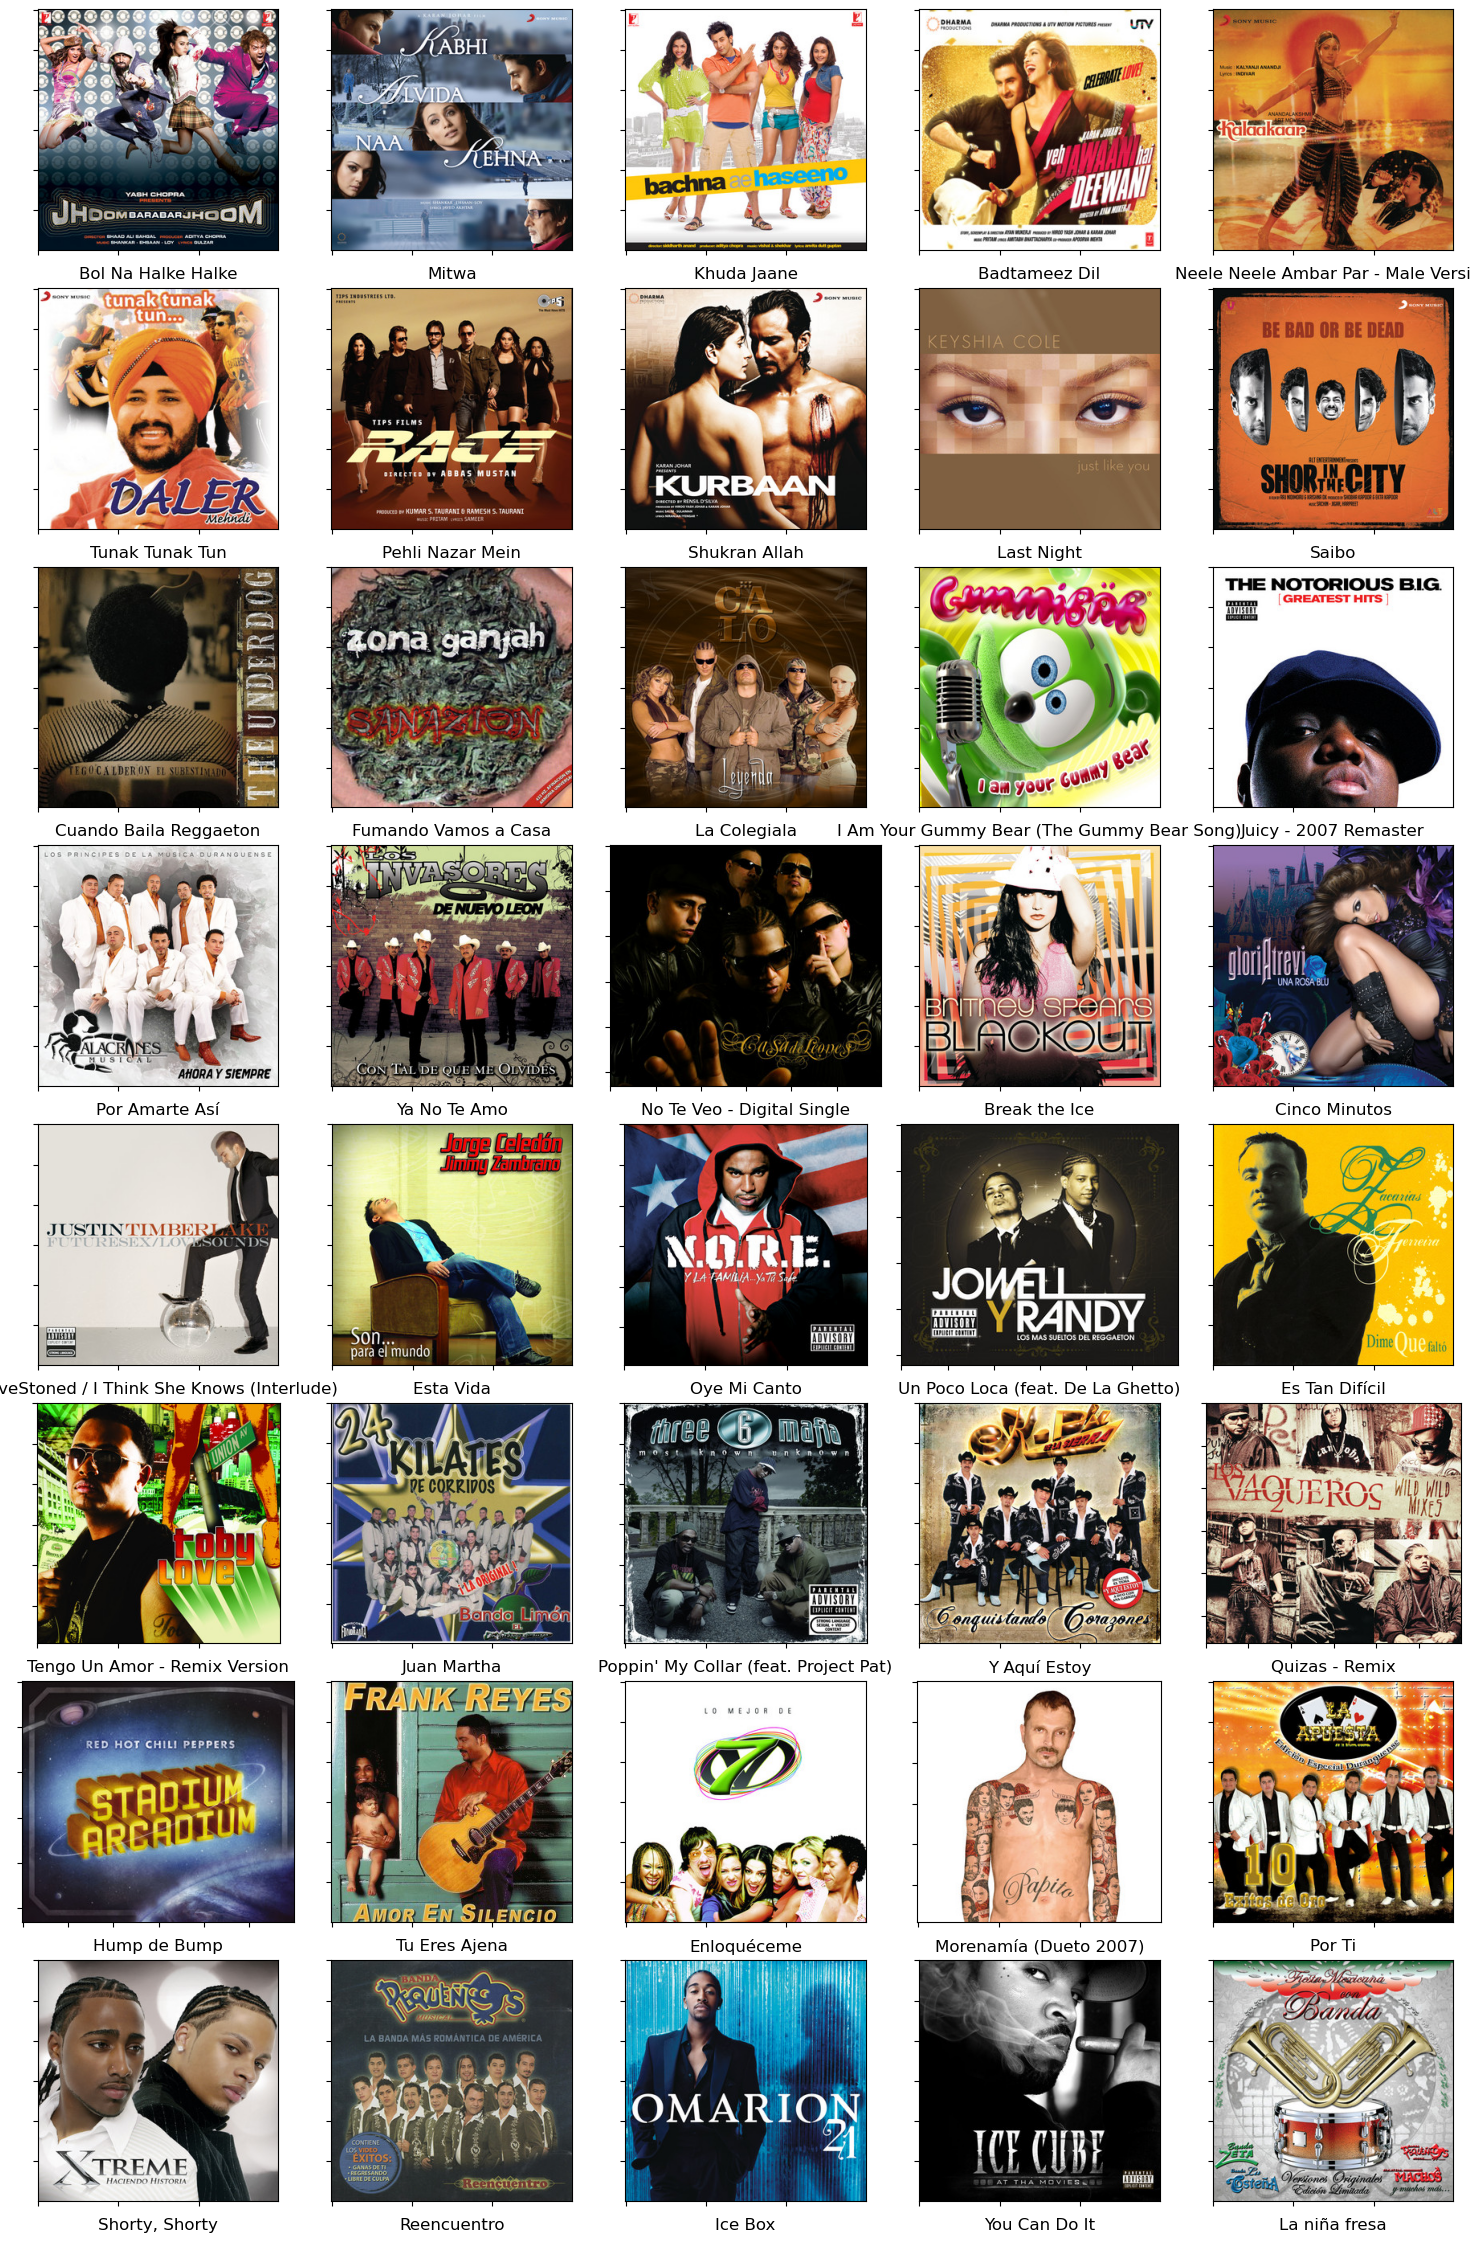

In [77]:
visualize_songs(playlist_top40)